In [1]:
import os
os.getcwd()
os.chdir(r'/home/manhducnmd/Delphes-3.5.0')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import pickle

In [3]:
import ROOT
ROOT.gSystem.Load("libDelphes")

Welcome to JupyROOT 6.20/08


0

In [4]:
try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

In [23]:
Pt_background = []

P4_1_background = []
P4_2_background = []

Mjj_background = []

eta_1_background = []
eta_2_background = []

phi_1_background = []
phi_2_background = []

final_background_eta = []
final_background_phi = []
final_background_Pt = []

for k in range(0,30):
    if k < 3:
        inputFile= f'/home/manhducnmd/pp_dijet/Events/run_06_{k}/tag_2_delphes_events.root'
    else:
        inputFile= f'/home/manhducnmd/pp_dijet/Events/run_06_{k}/tag_1_delphes_events.root'
    chain = ROOT.TChain("Delphes")
    chain.Add(inputFile)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()
    print(numberOfEntries)
    # Get pointers to branches used in this analysis
    branchJet = treeReader.UseBranch("Jet")
    branchEFlowTrack = treeReader.UseBranch("EFlowTrack")
    branchEFlowPhoton = treeReader.UseBranch("EFlowPhoton")
    branchEFlowNeutralHadron = treeReader.UseBranch("EFlowNeutralHadron")
    

    for i in range(0, numberOfEntries): 
        treeReader.ReadEntry(i)

        if branchJet.GetEntries() >= 2:
            jet1 = branchJet.At(0)   # The first leading jet
            jet2 = branchJet.At(1)   # The second leading jet
            jetvec1= jet1.P4() 
            jetvec2= jet2.P4() 
            jet_total = jetvec1 + jetvec2
            if jetvec1.Pt() > 750 and jetvec2.Pt() > 750:
                if np.abs(jetvec1.Eta()) <= 2 and np.abs(jetvec1.Eta()) <=2:
                    Pt_background.append(jetvec1.Pt()) 
                
                    P4_1_background.append(jetvec1)
                    P4_2_background.append(jetvec2)
                
                    Mjj_background.append(jet_total.M())
                
                    eta_1_background.append(jetvec1.Eta())
                    eta_2_background.append(jetvec2.Eta())
                
                    phi_1_background.append(jetvec1.Phi())
                    phi_2_background.append(jetvec2.Phi())
                
                    constituent_background_eta = []
                    constituent_background_phi = []
                    constituent_background_Pt = []
                    #for constituent in jet1.Constituents: 
                        #constituent_background_eta.append(constituent.P4().Eta())
                        #constituent_background_phi.append(constituent.P4().Phi())
                        #constituent_background_Pt.append(constituent.P4().Pt())
                    for constituent_2 in jet2.Constituents:
                        constituent_background_eta.append(constituent_2.P4().Eta())
                        constituent_background_phi.append(constituent_2.P4().Phi())
                        constituent_background_Pt.append(constituent_2.P4().Pt())
                    final_background_eta.append(constituent_background_eta)
                    final_background_phi.append(constituent_background_phi)
                    final_background_Pt.append(constituent_background_Pt)
    
    chain.Reset()
Pt_background = np.array(Pt_background)

P4_1_background = np.array(P4_1_background)
P4_2_background = np.array(P4_2_background)

Mjj_background = np.array(Mjj_background)

eta_1_background = np.array(eta_1_background)
eta_2_background = np.array(eta_2_background)

phi_1_background = np.array(phi_1_background)
phi_2_background = np.array(phi_2_background)

100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000


In [34]:
# Grid settings
xpixels = np.arange(-1, 1, 2/50)
ypixels = np.arange(-1, 1, 2/50)

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[None,:] - xpixels[None,:,None]), axis = 1)
    ycoords = np.argmin(np.abs(phis[None,:] - ypixels[None,:,None]), axis = 1)
    z[xcoords[0][in_grid],ycoords[0][in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing(x ,y, jet_eta, jet_phi, weights, rotate=True, flip=True):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    #x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    #y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x_centroid = jet_eta
    y_centroid = jet_phi
    x = x - x_centroid
    y = y - y_centroid
    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]
        
        # Theta to x_axis, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
    
    n_flips = 0
  
    # Flipping
    if flip:
        if x_rot[np.argmax(weights)] < 0.:
            x_rot = -x_rot
            n_flips  += 1
        if y_rot[np.argmax(weights)] < 0.:
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img(etas, phis, jet_eta, jet_phi, pT, rotate, flip):
                    
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
                    
    weights = pT
    
    etas, phis = preprocessing(etas, phis, jet_eta, jet_phi, weights, rotate, flip)

    z_ori = orig_image(etas, phis, weights)
    
    return z_ori
        
    #print( "Cropping and normalising" )
    #n_crop = 40
    #z_new = np.zeros((z_ori.shape[0],n_crop, n_crop))
    #for i in range(z_ori.shape[0]):
        #Npix = z_ori[i,:,:].shape
        #z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        #if norm:
            #z_sum = z_new[i,:,:].sum()
            #if z_sum != 0.:
                #z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    #print( "Reshaping" )
    #z_out = z_new.reshape( (z_new.shape[0],-1) )
    


In [35]:
all_images_background_sr = []
all_images_background_sb = []
for idx, xd in enumerate(final_background_eta):
    etas = np.array(final_background_eta[idx])
    phis = np.array(final_background_phi[idx])
    Pts = np.array(final_background_Pt[idx])
    if 4700 <= Mjj_background[idx] <= 5500:
        all_images_background_sr.append(constit_to_img(etas, phis, eta_2_background[idx], phi_2_background[idx], 
                                                       Pts, True, True))
    elif  4400 <= Mjj_background[idx] <= 4700 or 5500 <= Mjj_background[idx] <= 5800:
        all_images_background_sb.append(constit_to_img(etas, phis, eta_2_background[idx], phi_2_background[idx],
                                                       Pts, True, True))
all_images_background_sr = np.array(all_images_background_sr)
all_images_background_sb = np.array(all_images_background_sb)

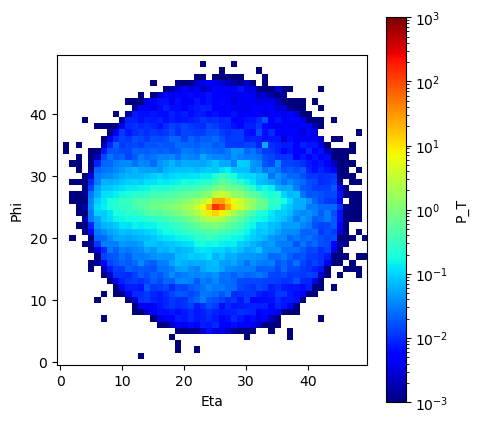

In [36]:
masked_data = np.ma.masked_equal(np.mean(all_images_background_sr[0:10000], axis = 0), 0.)

# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-3, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("P_T")
plt.xlabel("Eta")
plt.ylabel("Phi")
plt.gca().invert_yaxis()
plt.show()

In [38]:
print(len(all_images_background_sr), len(all_images_background_sb))

65859 66785


In [39]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')
with open('background_images_sr_50_jet_2.npy','wb') as f:
    np.save(f, all_images_background_sr)
with open('background_images_sb_50_jet_2.npy', 'wb') as g:
    np.save(g, all_images_background_sb)